<a href="https://colab.research.google.com/github/Dim0000n/Text-to-Image-CCVAE/blob/main/CCVAE_text_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

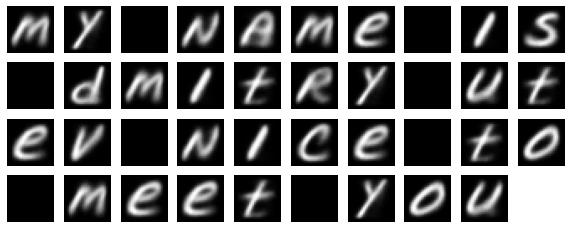

In [101]:
#НЕ ПЫТАЙТЕСЬ ЗАПУСТИТЬ ЭТО БЕЗ ЗАГРУЗКИ/ОБУЧЕНИЯ МОДЕЛИ
#DON'T TRY TO PROCESS IT WITHOUT MODEL TRAINING/DOWNLOADING
text2images('My name is Dmitry Utev, nice to meet you!')  

#Libraries import (Импорт библиотек)

In [1]:
!pip install emnist

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.layers import Dense,Flatten,Reshape,Input,Lambda, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout,concatenate, Conv2D,Conv2DTranspose

import keras.backend as K

from emnist import extract_training_samples,extract_test_samples

#Data downloading (Загрузка данных)

In [3]:
#загружаем данные
xs_train,y_train=extract_training_samples('letters')
xs_test,y_test=extract_test_samples('letters')



In [4]:
xs_train.shape

(124800, 28, 28)

In [5]:
#добавляем размерность и нормаруем данные
x_train=np.expand_dims(xs_train,axis=-1)/255.
x_test=np.expand_dims(xs_test,axis=-1)/255.

In [6]:
x_train.shape

(124800, 28, 28, 1)

In [7]:
#приведем лейблы к значениям 0..25 (изначальные значения 1..26)
y_test=y_test-1
y_train=y_train-1

In [8]:
num_classes=26 #количество классов

#переведем метки в one hot encoding
y_train_cat=keras.utils.to_categorical(y_train,num_classes)
y_test_cat=keras.utils.to_categorical(y_test,num_classes)

#CVAE creation (Создание CVAE)

In [24]:
hidden_dim=2 #размерность скрытого пространства CVAE

In [15]:
#функция создания блока энкоденра
def encoderBlock (inputs,  #входной тензор
                  neu=8,   #число нейронов
                  kernel=3, #размер ядра
                  strides=1): #шаг ядра
    
    x=Conv2D(neu,kernel_size=kernel,strides=strides,padding="same") (inputs)
    x=BatchNormalization()(x)
    x=LeakyReLU() (x)

    return x

In [16]:
#функция создания блока декодера
def decoderBlock(
    inputs,
    neu=8,
    kernel=3,
    strides=1
):

  x=Conv2DTranspose(neu,kernel_size=kernel,strides=strides,padding='same') (inputs)
  x=BatchNormalization()(x)
  x=LeakyReLU()(x)

  return x

##Encoder

In [25]:
#архитектура энкодера

#ветка изображения
input_img=Input(shape=(28,28,1))
x=encoderBlock(input_img,neu=32,kernel=3,strides=1)
x=encoderBlock(x,neu=64,kernel=3,strides=2)
x=encoderBlock(x,neu=64,kernel=3,strides=2)
x=encoderBlock(x,neu=64,kernel=3,strides=1)
flatten=Flatten() (x)

#вход лейбла
lb=Input(shape=(num_classes,))  

x=concatenate([flatten,lb])
x=Dense(2,activation='linear') (x)

In [26]:
z_mean=Dense(hidden_dim)(x)       #мат ожидание
z_log_var=Dense(hidden_dim) (x)  #логарифм дисперсии


In [27]:
#создание нормального распределения

def noiser(args):
  
  z_mean, z_log_var=args
  N=K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.)

  return K.exp(z_log_var/2)*N+z_mean

#создадим кастомный слой
h=Lambda(noiser,output_shape=(hidden_dim,)) ([z_mean,z_log_var])

In [28]:
#Собираем энкодер
encoder=keras.Model([input_img,lb],[z_mean,z_log_var,h],name='encoder')

##Decoder

In [29]:
#архитектура декодера
input_dec=Input(shape=(2,))
lb_dec=Input(shape=(num_classes,))

d=concatenate([input_dec,lb_dec])
x=Dense(3136) (d)                #количество нейронов 7*7*64
x=Reshape((7,7,64)) (x)
x=decoderBlock(x,neu=64,kernel=3,strides=1)
x=decoderBlock(x,neu=64,kernel=3,strides=2)
x=decoderBlock(x,neu=64,kernel=3,strides=2)

decoded=Conv2DTranspose(1,3,1,padding='same',activation='sigmoid') (x)

In [30]:
#собираем декодер
decoder=keras.Model([input_dec,lb_dec],decoded,name='decoder')

##CVAE

In [35]:
#получим выходы
outputs=decoder([encoder([input_img,lb])[2],lb_dec])

In [36]:
#соберем cvae
cvae=keras.Model([input_img,lb,lb_dec],outputs,name='cvae')

##Loss

In [71]:
#ошибка восстановления изображения
reconstruction_loss=keras.losses.MSE(input_img,outputs)
reconstruction_loss*=28*28                              #убираем нормировку

#расстояние Кульбака-Лейблера
kl_loss=1+z_log_var-K.square(z_mean)-K.exp(z_log_var)
kl_loss=-0.5*K.sum(kl_loss,axis=-1)

#суммируем ошибку
cvae_loss=K.mean(reconstruction_loss)+K.mean(kl_loss)

#добавляем ошибку в модель
cvae.add_loss(cvae_loss)

#Training (Обучение)

In [72]:
cvae.compile(optimizer='adam')
history=cvae.fit([x_train,y_train_cat,y_train_cat],
        x_train,epochs=20,
        batch_size=100,shuffle=True)

Epoch 1/20
1248/1248 [==============================] - 63s 49ms/step - loss: 48.3761
Epoch 2/20
1248/1248 [==============================] - 61s 49ms/step - loss: 43.7512
Epoch 3/20
1248/1248 [==============================] - 60s 48ms/step - loss: 42.5075
Epoch 4/20
1248/1248 [==============================] - 60s 48ms/step - loss: 41.8287
Epoch 5/20
1248/1248 [==============================] - 60s 48ms/step - loss: 41.3499
Epoch 6/20
1248/1248 [==============================] - 60s 48ms/step - loss: 41.0239
Epoch 7/20
1248/1248 [==============================] - 60s 48ms/step - loss: 40.7928
Epoch 8/20
1248/1248 [==============================] - 60s 48ms/step - loss: 40.5858
Epoch 9/20
1248/1248 [==============================] - 61s 49ms/step - loss: 40.4351
Epoch 10/20
1248/1248 [==============================] - 61s 49ms/step - loss: 40.2754
Epoch 11/20
1248/1248 [==============================] - 60s 48ms/step - loss: 40.1198
Epoch 12/20
1248/1248 [=============================

In [105]:
history1=cvae.fit([x_train,y_train_cat,y_train_cat],
        x_train,epochs=10,
        batch_size=100,shuffle=True)

Epoch 1/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.3673
Epoch 2/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.2823
Epoch 3/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.2302
Epoch 4/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.1870
Epoch 5/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.1551
Epoch 6/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.1223
Epoch 7/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.0734
Epoch 8/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.0424
Epoch 9/10
1248/1248 [==============================] - 60s 48ms/step - loss: 39.0050
Epoch 10/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.9655


In [106]:
history2=cvae.fit([x_train,y_train_cat,y_train_cat],
        x_train,epochs=10,
        batch_size=100,shuffle=True)

Epoch 1/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.9336
Epoch 2/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.9078
Epoch 3/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.8629
Epoch 4/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.8525
Epoch 5/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.8326
Epoch 6/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.7895
Epoch 7/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.7418
Epoch 8/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.7313
Epoch 9/10
1248/1248 [==============================] - 59s 48ms/step - loss: 38.7298
Epoch 10/10
1248/1248 [==============================] - 59s 47ms/step - loss: 38.6937


In [107]:
history3=cvae.fit([x_train,y_train_cat,y_train_cat],
        x_train,epochs=10,
        batch_size=100,shuffle=True)

Epoch 1/10
1248/1248 [==============================] - 61s 49ms/step - loss: 38.6741
Epoch 2/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.6550
Epoch 3/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.6188
Epoch 4/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.6190
Epoch 5/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.5890
Epoch 6/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.5611
Epoch 7/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.5477
Epoch 8/10
1248/1248 [==============================] - 61s 49ms/step - loss: 38.5279
Epoch 9/10
1248/1248 [==============================] - 61s 49ms/step - loss: 38.5073
Epoch 10/10
1248/1248 [==============================] - 60s 48ms/step - loss: 38.4937


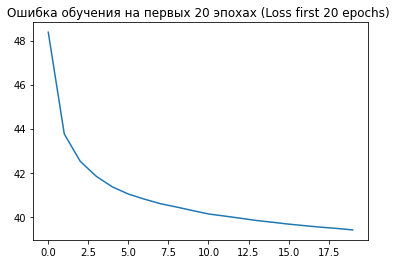

In [118]:
plt.plot(history.history['loss'])
plt.title("Ошибка обучения на первых 20 эпохах (Loss first 20 epochs) ")
plt.show()

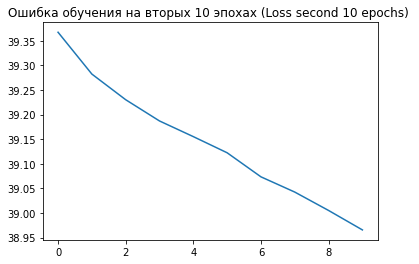

In [119]:
plt.plot(history1.history['loss'])
plt.title("Ошибка обучения на вторых 10 эпохах (Loss second 10 epochs) ")
plt.show()

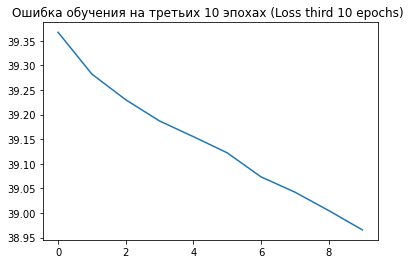

In [120]:
plt.plot(history1.history['loss'])
plt.title("Ошибка обучения на третьих 10 эпохах (Loss third 10 epochs) ")
plt.show()

#Testing 

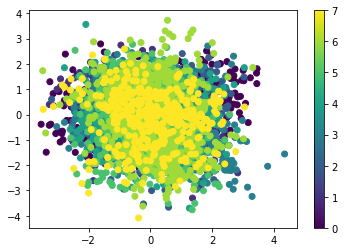

In [121]:
#визуализация распределения скрытого пространства
results=encoder.predict([x_test[:6000],y_test_cat[:6000]])

plt.scatter(results[2][:,0],results[2][:,1],c=y_test[:6000],cmap='viridis')
plt.colorbar()
plt.show()

In [38]:
#функция генерации символа lb_char класс символа 0..25
def genCharacter(lb_char):
  
  input_lb=np.zeros((1,num_classes))
  input_lb[0,lb_char]=1
  img=decoder.predict([np.random.normal(scale=1.,size=(1,hidden_dim)),input_lb])
  plt.imshow(img.squeeze(),cmap='gray')
  plt.show()

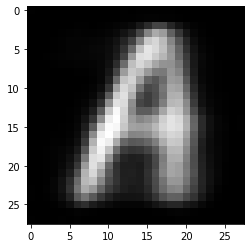

In [41]:
genCharacter(0)

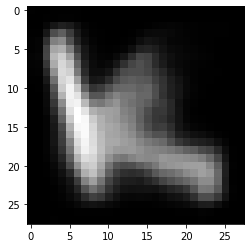

In [128]:
genCharacter(10)

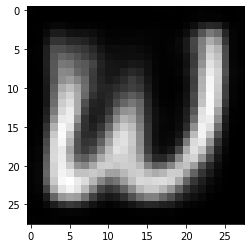

In [97]:
genCharacter(22)

#Models saving (схранение моделей)

In [9]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [131]:


#сохраним веса моделей
encoder.save_weights('/content/drive/MyDrive/PotsUAI/CVAE_text_visualisation/encoder_weights_.h5')
decoder.save_weights('/content/drive/MyDrive/PotsUAI/CVAE_text_visualisation/dencoder_weights_.h5')

#Loading models

Если вы хотите запустить предобученную модель, то сначала необходимо собрать энкодер и декодер, затем загрузить веса и завершить сборку автоэнкодера. Данную процедуру необходимо выполнить из-за невозможности сохранения все модели сразу, в следсдвие использования кастомного слоя.   

In [11]:
hidden_dim=3
num_classes=26

In [34]:
#загрузка весов
encoder.load_weights('/content/drive/MyDrive/PotsUAI/CVAE_text_visualisation/encoder_weights_.h5')
decoder.load_weights('/content/drive/MyDrive/PotsUAI/CVAE_text_visualisation/dencoder_weights_.h5')

In [ ]:
#оконачельная сборка модели
outputs=decoder([encoder([input_img,lb])[2],lb_dec])
cvae=keras.Model([input_img,lb,lb_dec],outputs,name='cvae')

#Text to images

In [42]:
#словарь классов
letter_class={
 'a':0,
 'b':1,
 'c':2,
 'd':3,
 'e':4,
 'f':5,
 'g':6,
 'h':7,
 'i':8,
 'j':9,
 'k':10,
 'l':11,
 'm':12,
 'n':13,
 'o':14,
 'p':15,
 'q':16,
 'r':17,
 's':18,
 't':19,
 'u':20,
 'v':21,
 'w':22,
 'x':23,
 'y':24,
 'z':25,
}

In [93]:
'''
функция перевода текста в изображения
text - входная строка
style_transaction=True  - все буквы написаны в одном стиле, Flase - в разных
'''
def text2images(text,style_transaction=True):
 
  hidden=np.random.normal(scale=1.,size=(1,hidden_dim)) #получаем вектор скрытого пространства
 
    
  letters=list(text);              #получаем набор букв
  keys=list(letter_class.keys())  #получаем все ключи алфавита

  #считаем количество строк по 10 картинок
  rows=0                     
  if len(letters)%10!=0:
    rows=int(len(letters)/10)+1
  else: 
    rows=int(len(letters)/10)
  
  ind=1  #индекс subplot
  plt.figure(figsize=(10,5)) #размер картинки
  
  for i in range(len(letters)):
    
    img=None                 #изображение
    if letters[i] in keys:   #если буква есть в словаре классов
      lb=np.zeros((1,num_classes))   #создаем лейбл
      lb[0,letter_class[letters[i].lower()]]=1
      if style_transaction:           #если переносим стиль 
        img=decoder.predict([hidden,lb]) #используем вектор hidden
      else:  #иначе генерируем случайное скрытое пространство
        img=decoder.predict([np.random.normal(scale=1.,size=(1,hidden_dim)),lb])
    elif i<len(letters)-1:      #если это не буква, и не знак завершения предложения
      if letters[i]==" ":        #если пробел
        img=np.zeros((28,28))   #генерируем пустой квадрат
      else:                     #если не пробел
        if letters[i+1]!=" ":  #и следующий символ не равен пробелу
          img=np.zeros((28,28)) #генерируем поустой квадрат
        else:
          continue  #если следом пробел, то заканчиваем итерацию цикла
    else:
      break

    plt.subplot(rows,10,ind)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.axis('off')
    ind+=1
  
  plt.show()



#Visualisation

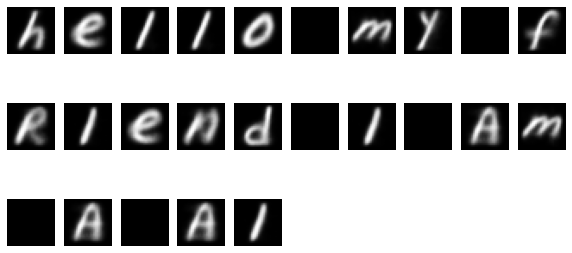

In [76]:
text2images('hello my friend, I am a AI') 

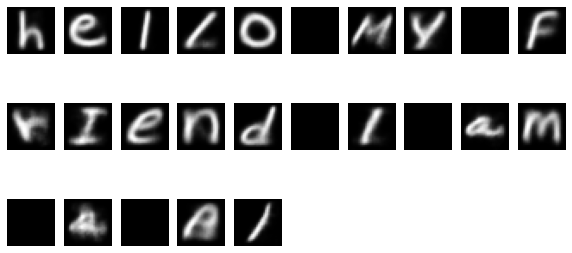

In [102]:
text2images('hello my friend, I am a AI', False) #буквы в разных стилях

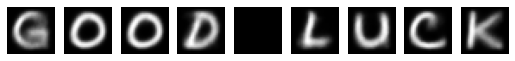

In [105]:
text2images('Good luck!')

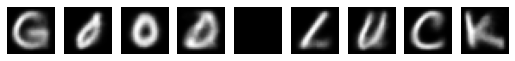

In [106]:
text2images('Good luck!',False)